<a href="https://colab.research.google.com/github/tenoob/Sementic-Segmentation/blob/dev/unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patchify

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow

In [3]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset'

In [4]:
patch_size = 256
scaler = MinMaxScaler()
image_dset = []
mask_dset = []

In [5]:
# read images and masks
for image_type in ['images', 'masks']:
    image_extension = 'jpg' if image_type == 'images' else 'png'
    for tile_id in range(1,9):
        for image_id in range(1,20):
            image = cv2.imread(f'{root_dir}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
            if image is not None:
                print(f'{root_dir}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}')
                if image_type == 'masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image_width = (image.shape[1]//patch_size)*patch_size
                image_height = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image) #convert img from ndarray to pil.image
                image = image.crop((0,0,image_width,image_height))
                image = np.array(image)  #convert the img back to nparray
                patch_img = patchify(image,(patch_size,patch_size,3),step = patch_size)
                #print(type(patch_img),patch_img.shape)
                for i in range(patch_img.shape[0]):
                    for j in range(patch_img.shape[1]):
                        if image_type == 'images':
                            small_pathes = patch_img[i,j,:,:]
                            small_pathes = scaler.fit_transform(small_pathes.reshape(-1,small_pathes.shape[-1])).reshape(small_pathes.shape)
                            small_pathes = small_pathes[0]  #remove unwanted patchify dimensions
                            image_dset.append(small_pathes)
                        elif image_type == 'masks':
                            small_pathes = patch_img[i,j,:,:]
                            small_pathes = small_pathes[0]  #remove unwanted patchify dimensions
                            mask_dset.append(small_pathes)


/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
/content/d

In [6]:
print(type(image_dset),type(mask_dset))


<class 'list'> <class 'list'>


In [7]:
image_dset = np.array(image_dset)
mask_dset = np.array(mask_dset)

In [8]:
image_dset.shape , mask_dset.shape

((1305, 256, 256, 3), (1305, 256, 256, 3))

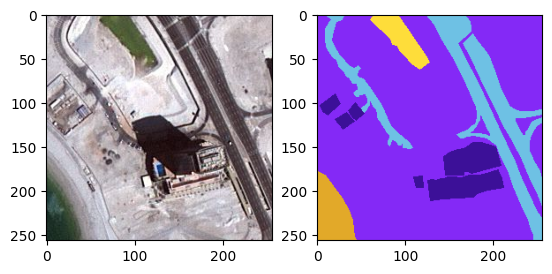

In [9]:
import random

random_number = random.randint(0,len(image_dset))
plt.subplot(121)
plt.imshow(image_dset[random_number])
plt.subplot(122)
plt.imshow(mask_dset[random_number])

In [10]:
label = small_pathes

In [11]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [12]:
def rgb_2_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0] # need just 1 channel now, no 3 channels
  return label_segment

In [13]:
labels = []
for i in range(mask_dset.shape[0]):
    new_label = rgb_2_label(mask_dset[i])
    labels.append(new_label)

In [14]:
labels = np.array(labels)
labels.shape

(1305, 256, 256)

In [15]:
labels = np.expand_dims(labels,axis=3)
labels.shape

(1305, 256, 256, 1)

In [16]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [17]:
labels[2]

array([[[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

array([[[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       ...,

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]],

       [[132,  41, 246],
        [132,  41, 246],
        [132,  41, 246],
        ...,
        [132,  41, 246],
        [132,  41, 246],
        [132,  41, 246]]], dtype=uint8)
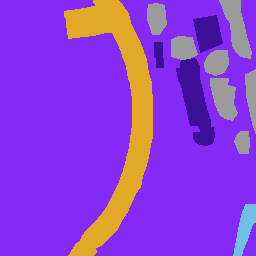

In [18]:
mask_dset[0]

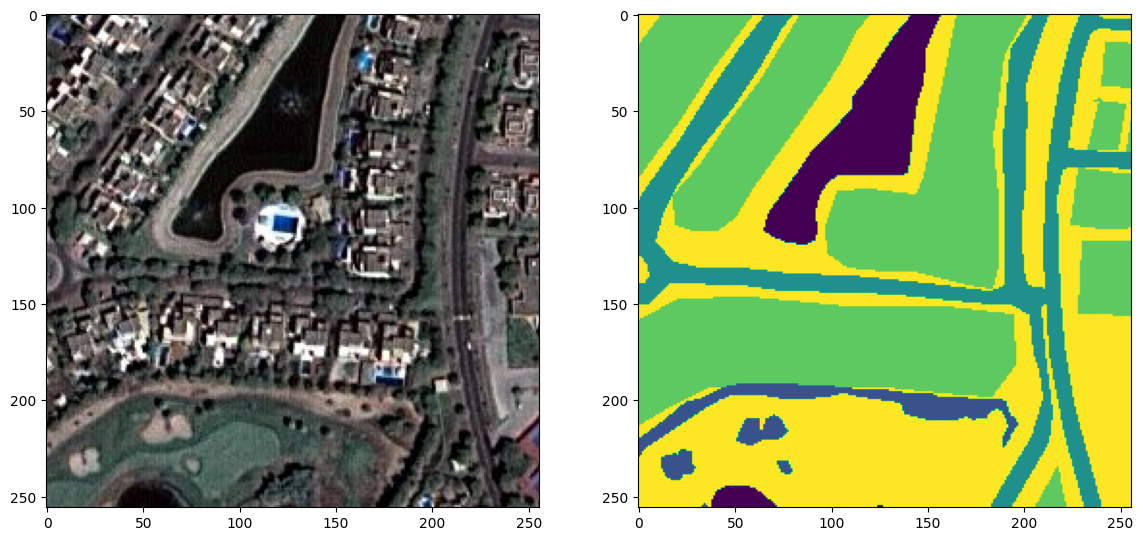

In [19]:
random_image_id = random.randint(0, len(image_dset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [20]:
from keras.utils import to_categorical

categorical_classes = len(np.unique(labels))
categorical_labels = to_categorical(labels,num_classes=categorical_classes)



In [21]:
categorical_labels.shape

(1305, 256, 256, 6)

In [22]:
#train Test split

from sklearn.model_selection import train_test_split

x_train , x_test , y_train ,y_test = train_test_split(image_dset,categorical_labels, test_size=0.20 , random_state = 50)

In [23]:
x_train.shape , type(x_train)

((1044, 256, 256, 3), numpy.ndarray)